In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier


In [6]:
filename = 'versicolor-virginica'

data = pd.read_csv(f'iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-versicolor'] = 1
t[t == 'Iris-virginica'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = 0.4, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

In [7]:
read_from_files = False

## Tuning parameters for qSVM

In [8]:
B_values = [2, 3, 5, 10]
K_values = [2, 3]
R_values = [0, 1, 3, 5]
gamma_values = [-1] + [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

run = not read_from_files

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func)

    np.save(f'results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'results/QUBO-{filename}-time', times)

Progress: 100%|██████████| 224/224 [07:30<00:00,  2.01s/it]


## Tuning parameters for kSVM

In [12]:
C_values = [2, 6, 3, 5, 9, 10, 15, 30]
gamma_values = [-1] + [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = not read_from_files

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'results/kSVM-{filename}-time', times)

Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Progress: 100%|██████████| 56/56 [00:08<00:00,  6.55it/s]


## Get data from files

In [13]:
qSVM_accuracy = np.load(f'results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'results/kSVM-{filename}-auroc.npy')

In [14]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 2, 4, 7), (8, 7))

## Best models
Finding best models based on Accuracy and then plotting them

In [28]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 0.925 
 cSVM best auroc 1.0 

qSVM best accuracy 0.89 
 qSVM best auroc 0.975 



In [23]:
val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

#top_model_acc = [qSVM_accuracy[index] for index in model_indices]
#top_model_auc = [qSVM_auroc[index] for index in model_indices]

In [24]:
tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

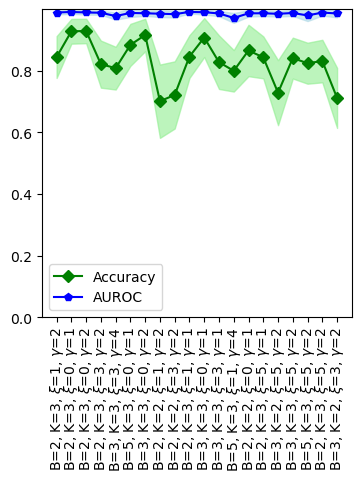

In [25]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.show()

## cSVM performance

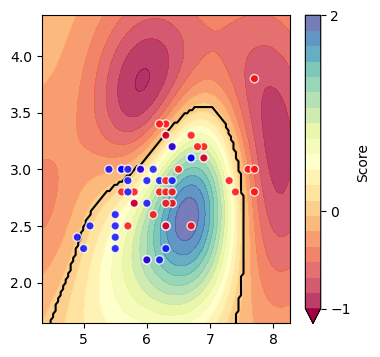

In [18]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = SoftMarginKernelClassifier(15, kernel_func, 1)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
c_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True)

## qSVM performance

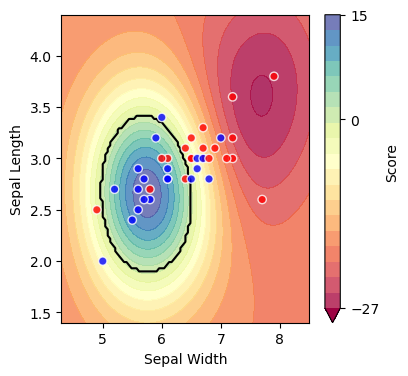

In [19]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = QUBOSoftMarginClassifier(2, 3, 5, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_train[:, dimensions]
plot_t_test = t_train

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

### Probability distribution of the models

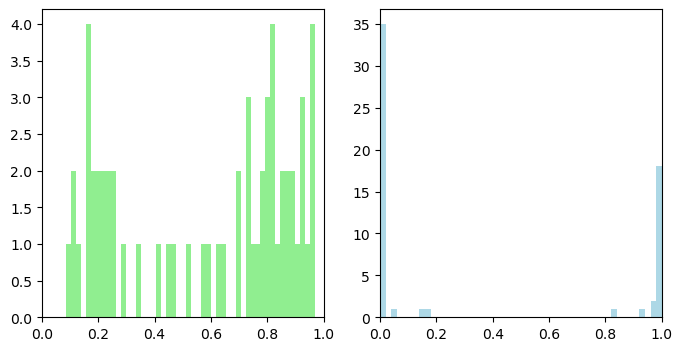

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].hist(c_prob_dist, label = 'cSVM probability distribution', color = 'lightgreen', bins = 50)
ax[1].hist(q_prob_dist, label = 'qSVM probability distribution', color = 'lightblue', bins = 50)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

In [ ]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 2, 4, 7), (8, 7))

## Variance

4 different values of R. For each other combination of the other 3 hyper-parameters -- B, K, gamma -- what is the variance of R as it varies. <br>
We end up with a 4x2x7 matrix with each element corresponding to the variance of the results for each different combination of B, K, gamma, which is then the variance over R. <br>
Would the variance of the variance the hyper-parameter be useful? <br>
Would the mean of the variance for each hyper-parameter be useful? No. <br>
Ok, basically both of them might be a better indication as to how important the parameters are. They can define a distribution which will be easier to understand than a list of numbers.
Where the variance appears would also be useful, but might be a little too in depth for the current level of analysis.
<br>
Note: cSVM nailed the classification, so it doesn't have any variance.

In [21]:
"""QUBO SVM"""

qSVM_variances = {'B': {}, 'K': {}, 'R': {}, 'gamma': {}}

for i, key in enumerate(list(qSVM_variances.keys())):
    auc = np.var(qSVM_auroc, axis = i)
    acc = np.var(qSVM_accuracy, axis = i)
    qSVM_variances[key]['auc'] = (np.mean(auc), np.var(auc))
    qSVM_variances[key]['acc'] = (np.mean(acc), np.var(acc))

In [22]:
display(qSVM_variances)

{'B': {'auc': (8.952287946428584e-05, 7.197255309747222e-09),
  'acc': (0.00031222795758928574, 6.328000706069327e-08)},
 'K': {'auc': (4.031808035714284e-05, 5.5615600274533635e-09),
  'acc': (0.0025473074776785716, 6.503661464574387e-06)},
 'R': {'auc': (5.4380580357142915e-05, 2.8734409565828297e-09),
  'acc': (0.002532373046874999, 7.8086334667887e-06)},
 'gamma': {'auc': (0.09799894770408163, 5.966084996119761e-06),
  'acc': (0.01407141262755102, 1.634235181930014e-05)}}

## C, R, and Gamma

In [ ]:
C_values = np.zeros((len(B_values), len(K_values)))

for i, B in enumerate(B_values):
    for j, K in enumerate(K_values):
       C_values[i, j] = np.sum([B ** k for k in range(K)])
C_values = C_values.flatten()
C_values

array([  3.,   7.,   4.,  13.,   6.,  31.,  11., 111.])

In [ ]:
C_qSVM_accuracy = np.array([qSVM_accuracy[i, j, :, :] for i in range(len(B_values)) for j in range(len(K_values))])

In [ ]:
C_qSVM_accuracy

array([[[0.4425, 0.99  , 0.9925, 0.99  , 0.975 , 0.9625, 0.97  ],
        [0.4475, 0.95  , 0.9525, 0.9725, 0.955 , 0.9475, 0.925 ],
        [0.455 , 0.705 , 0.9225, 0.9375, 0.92  , 0.8975, 0.8525],
        [0.4475, 0.635 , 0.83  , 0.91  , 0.9125, 0.8675, 0.8825]],

       [[0.37  , 0.9975, 0.995 , 0.9975, 0.985 , 0.9875, 0.9875],
        [0.34  , 0.985 , 0.985 , 0.9975, 0.9875, 0.9825, 0.9725],
        [0.33  , 0.95  , 0.9825, 0.9875, 0.9875, 0.9725, 0.945 ],
        [0.34  , 0.9675, 0.9875, 0.9875, 0.99  , 0.965 , 0.945 ]],

       [[0.415 , 0.9775, 0.985 , 0.995 , 0.995 , 0.98  , 0.935 ],
        [0.4475, 0.935 , 0.98  , 0.9925, 0.97  , 0.95  , 0.9025],
        [0.4125, 0.7275, 0.89  , 0.92  , 0.91  , 0.8975, 0.89  ],
        [0.38  , 0.7275, 0.9125, 0.9025, 0.9125, 0.885 , 0.8475]],

       [[0.3125, 0.99  , 0.995 , 0.995 , 0.9875, 0.995 , 0.9825],
        [0.2925, 0.98  , 0.9925, 0.9925, 0.985 , 0.975 , 0.9425],
        [0.32  , 0.9675, 0.9875, 0.985 , 0.9775, 0.9825, 0.9375],
    

In [ ]:
print(np.unravel_index(np.argmax(qSVM_accuracy), qSVM_accuracy.shape))
print(B_values[0], K_values[1], R_values[0], gamma_values[1])

(0, 1, 0, 1)
2 3 0 0.125
